In [22]:
!pip install sparse_lmm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import pandas as pd
import numpy as np

clinical_data = pd.read_csv('TCGA dataset/TCGA_Rectal_Cancer_(READ)/TCGA.READ.sampleMap_READ_clinicalMatrix', sep='\t', index_col=0)
gene_data = pd.read_csv('TCGA dataset/TCGA_Rectal_Cancer_(READ)/TCGA.READ.sampleMap_HiSeqV2_PANCAN.gz', sep='\t', index_col=0)

In [24]:
clinical_data.head()

,AWG_MLH1_silencing,AWG_cancer_type_Oct62011,CDE_ID_3226963,CIMP,MSI_updated_Oct62011,_INTEGRATION,_PANCAN_CNA_PANCAN_K8,_PANCAN_Cluster_Cluster_PANCAN,_PANCAN_DNAMethyl_PANCAN,_PANCAN_RPPA_PANCAN_K8,...,_GENOMIC_ID_TCGA_READ_gistic2,_GENOMIC_ID_TCGA_READ_RPPA_RBN,_GENOMIC_ID_data/public/TCGA/READ/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_READ_PDMarray,_GENOMIC_ID_data/public/TCGA/READ/miRNA_GA_gene,_GENOMIC_ID_TCGA_READ_gistic2thd,_GENOMIC_ID_TCGA_READ_exp_GAV2_exon,_GENOMIC_ID_TCGA_READ_mutation_bcm_solid_gene,_GENOMIC_ID_TCGA_READ_exp_HiSeqV2_percentile,_GENOMIC_ID_TCGA_READ_exp_HiSeqV2_exon
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-AF-2687-01,NaN,NaN,MSS,NaN,NaN,TCGA-AF-2687-01,COAD-READ,NaN,COADREAD non-CIMP c11,NaN,...,TCGA-AF-2687-01A-02D-1732-01,NaN,TCGA-AF-2687-01,NaN,NaN,TCGA-AF-2687-01A-02D-1732-01,NaN,NaN,c2a39a12-e882-49aa-a5fa-5356e4bcb823,c2a39a12-e882-49aa-a5fa-5356e4bcb823
TCGA-AF-2689-01,0.0,Rectum,MSS,CIMP.L,MSS,TCGA-AF-2689-01,COAD-READ,C7-COAD/READ,COADREAD CIMPL c10,COADREAD-like c7,...,TCGA-AF-2689-01A-01D-1549-01,TCGA-AF-2689-01A-21-1932-20,NaN,TCGA-AF-2689-01,TCGA-AF-2689-01,TCGA-AF-2689-01A-01D-1549-01,NaN,TCGA-AF-2689-01A-01W-0831-10,NaN,NaN
TCGA-AF-2689-11,0.0,Rectum,MSS,CIMP.L,MSS,TCGA-AF-2689-11,NaN,C7-COAD/READ,NaN,NaN,...,NaN,NaN,TCGA-AF-2689-11,NaN,NaN,NaN,NaN,NaN,a061d300-0dec-42c6-a21c-13af7bba943d,a061d300-0dec-42c6-a21c-13af7bba943d
TCGA-AF-2690-01,NaN,NaN,MSS,NaN,NaN,TCGA-AF-2690-01,COAD-READ,NaN,COADREAD non-CIMP c11,COADREAD-like c7,...,TCGA-AF-2690-01A-02D-1732-01,TCGA-AF-2690-01A-11-1932-20,TCGA-AF-2690-01,NaN,NaN,TCGA-AF-2690-01A-02D-1732-01,NaN,NaN,dfcfd7e4-4475-4791-a549-c1778db32ae2,dfcfd7e4-4475-4791-a549-c1778db32ae2
TCGA-AF-2691-01,0.0,Rectum,MSS,CIMP.L,MSS,TCGA-AF-2691-01,COAD-READ,C7-COAD/READ,COADREAD CIMPL c10,NaN,...,TCGA-AF-2691-01A-01D-1549-01,NaN,NaN,TCGA-AF-2691-01,TCGA-AF-2691-01,TCGA-AF-2691-01A-01D-1549-01,a7fa7e33-58e4-4463-b697-61a9c58bf9e1,TCGA-AF-2691-01A-01W-0831-10,NaN,NaN


In [25]:
gene_fullname = 'APC gene'
gene = 'apc'
condition = 'obesity'
condition_col = 'initial_weight'
trait = 'Rectal Cancer'

# Get the feature dimension of clinical data, and the number of genes
col_offset = len(clinical_data.columns)
num_genes = len(gene_data)
print(f'The clinical dataset has {col_offset} features, and the gene dataset includes {num_genes} genes')
gene_data.T

The clinical dataset has 130 features, and the gene dataset includes 20530 genes


sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-DC-6156-01,0.335208,-1.158126,-0.531035,-0.258972,0.037722,0.45469,0.213206,-0.280046,-0.423399,-1.281772,...,-0.185478,1.163883,0.243267,-0.71799,-0.725177,0.383714,1.264073,0.181105,-0.050833,-0.014512
TCGA-DC-6160-01,0.452908,-2.582626,-0.531035,-0.526172,-1.281078,-0.18061,-1.392194,-1.741546,0.614501,-2.659572,...,-0.138478,-1.587117,-1.320833,-0.67099,-0.396077,-1.611586,-1.230827,-0.376995,-0.185733,0.227088
TCGA-EI-6512-01,1.179008,-0.892726,-0.010835,0.336228,-1.008778,-1.13891,-0.234294,-1.530446,-0.423399,-3.012172,...,-0.748878,-1.066917,-1.016933,-1.28139,-0.329877,-1.096686,-0.723827,0.559205,0.665867,0.002688
TCGA-DC-5869-01,0.163108,0.122474,-0.531035,-0.787272,-0.677478,0.43529,-0.724594,-0.102046,-0.423399,-1.894772,...,-0.748878,-1.587117,-0.937033,0.00971,-0.718577,-0.896086,-0.185127,0.646205,0.165167,0.689388
TCGA-EI-6507-01,0.126508,-0.709026,-0.531035,0.390328,-0.478478,0.11299,-0.455494,-1.828246,0.103201,-0.896872,...,-0.748878,-1.587117,-0.222033,-1.28139,-0.017477,0.531814,1.234173,-0.591095,-3.495633,0.376488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EI-6506-01,1.454808,-2.553926,-0.531035,-0.265672,-0.995878,-0.49541,-1.272894,-0.991746,0.443801,-1.707372,...,-0.748878,1.081083,-0.566833,-0.12039,-0.402677,-1.149886,-0.160927,-0.052995,-0.322033,0.628488
TCGA-AF-2692-11,0.869808,2.152274,-0.531035,0.101328,0.291422,-0.21881,-0.384594,1.305554,0.616201,-2.922572,...,0.290722,0.588783,0.224767,-1.28139,-0.443377,1.866614,0.814473,0.265905,1.950067,0.584788
TCGA-AF-A56K-01,0.855608,1.167674,-0.531035,-0.667272,-1.362078,-0.58551,-0.252594,1.115054,0.503901,-1.402672,...,0.738322,2.082183,-0.294133,1.29381,-0.323777,0.397314,1.159573,0.128405,1.245367,0.064688
TCGA-DC-6154-01,1.480208,0.547374,-0.531035,-0.223772,-1.223678,-0.22171,-0.701294,0.759954,-0.423399,-0.973872,...,0.685722,1.297783,-0.522733,0.54831,-0.656177,-0.498286,0.433673,0.684005,-0.292333,0.630788


In [26]:
# Merge clinical_data and gene_data on their indices - sample_ID, corresponding to each person
merged_data = clinical_data.join(gene_data.T)

merged_data.head()

,AWG_MLH1_silencing,AWG_cancer_type_Oct62011,CDE_ID_3226963,CIMP,MSI_updated_Oct62011,_INTEGRATION,_PANCAN_CNA_PANCAN_K8,_PANCAN_Cluster_Cluster_PANCAN,_PANCAN_DNAMethyl_PANCAN,_PANCAN_RPPA_PANCAN_K8,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-AF-2687-01,NaN,NaN,MSS,NaN,NaN,TCGA-AF-2687-01,COAD-READ,NaN,COADREAD non-CIMP c11,NaN,...,0.139722,-1.587117,0.509567,0.85801,0.147323,0.852614,1.095073,-0.155195,1.547767,0.022788
TCGA-AF-2689-01,0.0,Rectum,MSS,CIMP.L,MSS,TCGA-AF-2689-01,COAD-READ,C7-COAD/READ,COADREAD CIMPL c10,COADREAD-like c7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-AF-2689-11,0.0,Rectum,MSS,CIMP.L,MSS,TCGA-AF-2689-11,NaN,C7-COAD/READ,NaN,NaN,...,0.380022,0.167283,0.671867,-1.28139,-0.766577,1.633314,-0.394927,0.398105,1.410667,0.948188
TCGA-AF-2690-01,NaN,NaN,MSS,NaN,NaN,TCGA-AF-2690-01,COAD-READ,NaN,COADREAD non-CIMP c11,COADREAD-like c7,...,-0.200178,1.895983,0.825967,-0.33609,-0.037277,1.156814,1.035173,0.081205,3.199267,0.744988
TCGA-AF-2691-01,0.0,Rectum,MSS,CIMP.L,MSS,TCGA-AF-2691-01,COAD-READ,C7-COAD/READ,COADREAD CIMPL c10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Only select relevant columns
input_cols = [condition_col] + merged_data.columns[col_offset: col_offset + num_genes].tolist()
merged_data = merged_data[input_cols]

# Remove sample rows with missing columns.
threshold_rows = 0.8 * len(merged_data)
rows_after_any = len(merged_data.dropna(how='any'))

# Prefer "how='any'", if it does not discard too much data.
if rows_after_any >= threshold_rows:
    merged_data = merged_data.dropna(how='any')
else:
    merged_data = merged_data.dropna(how='all')
    merged_data = merged_data.fillna(0)

merged_data.head()

,initial_weight,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-AF-2687-01,0.0,0.410908,2.396474,-0.531035,-0.118372,-0.380378,0.05959,-0.754094,0.778654,0.088301,...,0.139722,-1.587117,0.509567,0.85801,0.147323,0.852614,1.095073,-0.155195,1.547767,0.022788
TCGA-AF-2689-11,0.0,0.975608,2.391874,-0.531035,0.163828,-0.083278,-0.26031,-0.558094,0.834754,0.705501,...,0.380022,0.167283,0.671867,-1.28139,-0.766577,1.633314,-0.394927,0.398105,1.410667,0.948188
TCGA-AF-2690-01,0.0,0.378808,-0.220626,-0.531035,-0.416872,-0.498578,0.44639,-0.800294,2.028054,-0.423399,...,-0.200178,1.895983,0.825967,-0.33609,-0.037277,1.156814,1.035173,0.081205,3.199267,0.744988
TCGA-AF-2691-11,0.0,0.882608,1.743474,0.302365,0.172928,0.085422,-0.30721,-0.868094,0.417154,0.696201,...,0.084522,-0.228817,0.226967,-1.28139,-1.042077,1.493014,-0.839027,0.407105,2.157267,1.244388
TCGA-AF-2692-11,0.0,0.869808,2.152274,-0.531035,0.101328,0.291422,-0.21881,-0.384594,1.305554,0.616201,...,0.290722,0.588783,0.224767,-1.28139,-0.443377,1.866614,0.814473,0.265905,1.950067,0.584788


In [28]:

def mark_tumor(row_index):
    last_two_digits = int(row_index[-2:])

    if 1 <= last_two_digits <= 9:
        return 1
    elif 10 <= last_two_digits <= 19:
        return 0
    else:
        return -1

# Use the apply function to add the trait column to merged_data
merged_data[trait] = merged_data.index.to_series().apply(mark_tumor)

merged_data.head()

,initial_weight,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,Rectal Cancer
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-AF-2687-01,0.0,0.410908,2.396474,-0.531035,-0.118372,-0.380378,0.05959,-0.754094,0.778654,0.088301,...,-1.587117,0.509567,0.85801,0.147323,0.852614,1.095073,-0.155195,1.547767,0.022788,1
TCGA-AF-2689-11,0.0,0.975608,2.391874,-0.531035,0.163828,-0.083278,-0.26031,-0.558094,0.834754,0.705501,...,0.167283,0.671867,-1.28139,-0.766577,1.633314,-0.394927,0.398105,1.410667,0.948188,0
TCGA-AF-2690-01,0.0,0.378808,-0.220626,-0.531035,-0.416872,-0.498578,0.44639,-0.800294,2.028054,-0.423399,...,1.895983,0.825967,-0.33609,-0.037277,1.156814,1.035173,0.081205,3.199267,0.744988,1
TCGA-AF-2691-11,0.0,0.882608,1.743474,0.302365,0.172928,0.085422,-0.30721,-0.868094,0.417154,0.696201,...,-0.228817,0.226967,-1.28139,-1.042077,1.493014,-0.839027,0.407105,2.157267,1.244388,0
TCGA-AF-2692-11,0.0,0.869808,2.152274,-0.531035,0.101328,0.291422,-0.21881,-0.384594,1.305554,0.616201,...,0.588783,0.224767,-1.28139,-0.443377,1.866614,0.814473,0.265905,1.950067,0.584788,0


In [29]:
input_cols = merged_data.columns.tolist()
gene_list = [col for col in input_cols if gene in col.lower()]

import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.show()

def plot_categorical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=df, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

def analyze_distributions(df, numerical_columns, categorical_columns):
    for col in numerical_columns:
        plot_numeric_distribution(df, col)

    for col in categorical_columns:
        plot_categorical_distribution(df, col)

# Sample usage:
analyze_distributions(merged_data, numerical_columns=[condition_col, *gene_list], categorical_columns=[trait])

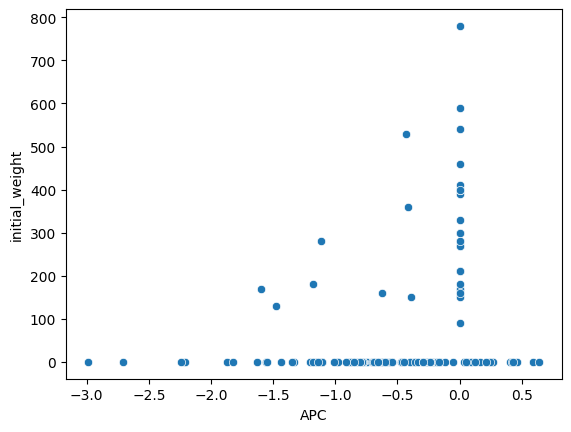

In [30]:
sns.scatterplot(data=merged_data, x='APC', y=condition_col)
plt.show()

In [31]:
# Convert "day_to_birth" to age in years
merged_data[condition_col] = (- merged_data[condition_col] / 365.25).astype(int)
merged_data = merged_data.rename(columns={condition_col: condition})
input_cols = merged_data.columns.tolist()

merged_data.head()

,obesity,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,Rectal Cancer
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA-AF-2687-01,0,0.410908,2.396474,-0.531035,-0.118372,-0.380378,0.05959,-0.754094,0.778654,0.088301,...,-1.587117,0.509567,0.85801,0.147323,0.852614,1.095073,-0.155195,1.547767,0.022788,1
TCGA-AF-2689-11,0,0.975608,2.391874,-0.531035,0.163828,-0.083278,-0.26031,-0.558094,0.834754,0.705501,...,0.167283,0.671867,-1.28139,-0.766577,1.633314,-0.394927,0.398105,1.410667,0.948188,0
TCGA-AF-2690-01,0,0.378808,-0.220626,-0.531035,-0.416872,-0.498578,0.44639,-0.800294,2.028054,-0.423399,...,1.895983,0.825967,-0.33609,-0.037277,1.156814,1.035173,0.081205,3.199267,0.744988,1
TCGA-AF-2691-11,0,0.882608,1.743474,0.302365,0.172928,0.085422,-0.30721,-0.868094,0.417154,0.696201,...,-0.228817,0.226967,-1.28139,-1.042077,1.493014,-0.839027,0.407105,2.157267,1.244388,0
TCGA-AF-2692-11,0,0.869808,2.152274,-0.531035,0.101328,0.291422,-0.21881,-0.384594,1.305554,0.616201,...,0.588783,0.224767,-1.28139,-0.443377,1.866614,0.814473,0.265905,1.950067,0.584788,0


In [32]:
import pandas as pd
from sparse_lmm import VariableSelection

# Select relevant columns and convert to numpy array
data_array = merged_data.values

# Normalize data
X = data_array
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
zero_std_columns = np.where(std == 0)[0]
X = (X - mean) / std
X[:, zero_std_columns] = 0

y = merged_data[trait].values

# Implementing k-fold cross-validation
def cross_validation(X, y, k=5):
    # Shuffle data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    fold_size = len(X) // k
    accuracies = []

    for i in range(k):
        # Split data into train and test based on the current fold
        test_indices = indices[i*fold_size : (i+1)*fold_size]
        train_indices = np.setdiff1d(indices, test_indices)

        X_train, X_test = X_shuffled[train_indices], X_shuffled[test_indices]
        y_train, y_test = y_shuffled[train_indices], y_shuffled[test_indices]

        # Use the precision_lasso package for regression
        var_select = VariableSelection()
        var_select.fit(X_train, y_train)
        predictions = var_select.predict(X_test)

        # Turn the predictions into binary values using a threshold of 0.5
        binary_predictions = (predictions > 0.5).astype(int)

        # Calculate accuracy for this fold
        accuracy = np.mean(binary_predictions == y_test)
        accuracies.append(accuracy)

    return np.mean(accuracies)

print(cross_validation(data_array, y))

C:\Users\Bobibob\AppData\Local\Temp\ipykernel_24488\2284219672.py:12: RuntimeWarning: invalid value encountered in divide
  X = (X - mean) / std
C:\Users\Bobibob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sparse_lmm\helpingMethods.py:49: RuntimeWarning: invalid value encountered in divide
  ts = beta / np.sqrt(var * sigma)
C:\Users\Bobibob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sparse_lmm\VariableSelection.py:183: RuntimeWarning: divide by zero encountered in log
  return -np.log(p), np.array(betas)


0.6832


In [33]:
# Conduct regression on the whole dataset
# Instantiate the VariableSelection class
var_select = VariableSelection()

# Fit the model
var_select.fit(X, y)

# Retrieve the coefficients
coefficients = var_select.getBeta().reshape(-1).tolist()
nlog_p_values = var_select.getNegLogP().reshape(-1).tolist()

In [34]:
# Print regression result

gene_result = []
condition_result = []

# Extract information related to the regressors
for var, coef, nlogp in zip(input_cols, coefficients, nlog_p_values):
    if gene in var.lower():
        gene_result.append((var, coef, np.exp(-nlogp)))
    if condition == var.lower():
        condition_result.append((var, coef, np.exp(-nlogp)))

regression_report = "Regression Results:\n\n"
regression_report += f"For {gene}:\n"
for variable_name, coefficient, p_value in gene_result:
    regression_report += f"{variable_name}: Coefficient = {coefficient}, p-value = {p_value}\n"

regression_report += f"\nFor {condition}:\n"
for variable_name, coefficient, p_value in condition_result:
    regression_report += f"{variable_name}: Coefficient = {coefficient}, p-value = {p_value}\n"

print(regression_report)

Regression Results:

For apc:
APC: Coefficient = -0.01902735266560135, p-value = 0.9110116179490108
SNAPC3: Coefficient = 0.014566346653052146, p-value = 0.9388796607663725
APCS: Coefficient = 0.012464791780473434, p-value = 0.9465828744362625
APC2: Coefficient = -0.026899347234569507, p-value = 0.8879928332926356
ANAPC1: Coefficient = -0.007048187505056102, p-value = 0.9803686076709935
ANAPC2: Coefficient = 0.007043224889361531, p-value = 0.9725479004488378
ANAPC5: Coefficient = 0.003664954224019634, p-value = 0.9828635772298027
ANAPC4: Coefficient = 0.006260988103896245, p-value = 0.9670782083527103
ANAPC7: Coefficient = 0.01115945727701129, p-value = 0.9566702039381525
APCDD1L: Coefficient = -0.03350312119989231, p-value = 0.8518955358540312
ANAPC16: Coefficient = -0.011970677365785451, p-value = 0.9497663608673026
ANAPC11: Coefficient = 0.004779162647145489, p-value = 0.9835261916928368
ANAPC10: Coefficient = 0.007608183557882966, p-value = 0.9659045200847372
ANAPC13: Coefficient =

In [35]:
# Generate hypothesis text

hypotheses_text = f'Hypothesis\n\n'
hypotheses_text += f'For the question "What is the relationship between {gene_fullname} and {trait} when considering the influence of {condition}?", the following hypotheses can be proposed:\n\n'
hypotheses_text += f'Null Hypothesis (H0): There is no significant association between the expression of the {gene_fullname} and {trait} when considering the influence of {condition}.\n\n'
hypotheses_text += f'Alternative Hypothesis (H1): There is an association between the expression of the {gene_fullname} and {trait} when considering the influence of {condition}.\n\n'

print(hypotheses_text)

Hypothesis

For the question "What is the relationship between APC gene and Rectal Cancer when considering the influence of obesity?", the following hypotheses can be proposed:

Null Hypothesis (H0): There is no significant association between the expression of the APC gene and Rectal Cancer when considering the influence of obesity.

Alternative Hypothesis (H1): There is an association between the expression of the APC gene and Rectal Cancer when considering the influence of obesity.




In [36]:
# Interpretation of Regression Coefficients

threshold = 0.05
def interpret_coefficient(variable_name, coefficient, p_value, significance_level=0.05):
    interpretation = f"Variable: {variable_name}\n"

    if coefficient > 0:
        interpretation += "Coefficient is positive, "
    elif coefficient < 0:
        interpretation += "Coefficient is negative, "
    else:
        interpretation += "Coefficient is zero, "

    if p_value < threshold:
        interpretation += f"and it is statistically significant (p-value < {threshold}).\n\n"
    else:
        interpretation += f"and it is not statistically significant (p-value >= {threshold}).\n\n"

    return interpretation

# Create a report to interpret coefficients and p-values for all variables
interpretation_coefficient_report = "Interpretation of Regression Coefficients:\n\n"

for variable_name, coefficient, p_value in gene_result + condition_result:
    interpretation_coefficient_report += interpret_coefficient(variable_name, coefficient, p_value, threshold)

print(interpretation_coefficient_report)

Interpretation of Regression Coefficients:

Variable: APC
Coefficient is negative, and it is not statistically significant (p-value >= 0.05).

Variable: SNAPC3
Coefficient is positive, and it is not statistically significant (p-value >= 0.05).

Variable: APCS
Coefficient is positive, and it is not statistically significant (p-value >= 0.05).

Variable: APC2
Coefficient is negative, and it is not statistically significant (p-value >= 0.05).

Variable: ANAPC1
Coefficient is negative, and it is not statistically significant (p-value >= 0.05).

Variable: ANAPC2
Coefficient is positive, and it is not statistically significant (p-value >= 0.05).

Variable: ANAPC5
Coefficient is positive, and it is not statistically significant (p-value >= 0.05).

Variable: ANAPC4
Coefficient is positive, and it is not statistically significant (p-value >= 0.05).

Variable: ANAPC7
Coefficient is positive, and it is not statistically significant (p-value >= 0.05).

Variable: APCDD1L
Coefficient is negative, an

In [37]:
# Hypothesis Confirmation and Conclusion

# Create a function to determine if H0 or H1 is confirmed
def confirm_hypothesis(coefficient, p_value, variable_name, significance_level=0.05):
    if p_value >= significance_level:
        return f"H0 is not rejected: There is insufficient evidence to conclude a significant association between the expression of the {variable_name} gene and {trait} when considering the influence of {condition}."
    elif coefficient != 0 and p_value < significance_level:
        return f"H1 is confirmed: There is an association between the expression of the {variable_name} and {trait} when considering the influence of {condition}.\n\n"

hypothesis_confirmation_report = "Hypothesis Confirmation and Conclusion:\n\n"

for variable_name, coefficient, p_value in gene_result:
    confirmation = confirm_hypothesis(coefficient, p_value, variable_name, threshold)
    hypothesis_confirmation_report += f"Variable: {variable_name}\n"
    hypothesis_confirmation_report += f"Conclusion: {confirmation}\n\n"

print(hypothesis_confirmation_report)

Hypothesis Confirmation and Conclusion:

Variable: APC
Conclusion: H0 is not rejected: There is insufficient evidence to conclude a significant association between the expression of the APC gene and Rectal Cancer when considering the influence of obesity.

Variable: SNAPC3
Conclusion: H0 is not rejected: There is insufficient evidence to conclude a significant association between the expression of the SNAPC3 gene and Rectal Cancer when considering the influence of obesity.

Variable: APCS
Conclusion: H0 is not rejected: There is insufficient evidence to conclude a significant association between the expression of the APCS gene and Rectal Cancer when considering the influence of obesity.

Variable: APC2
Conclusion: H0 is not rejected: There is insufficient evidence to conclude a significant association between the expression of the APC2 gene and Rectal Cancer when considering the influence of obesity.

Variable: ANAPC1
Conclusion: H0 is not rejected: There is insufficient evidence to co